# **MobileNet Pytorch**

### **1. PreProcessing Data**

##### **1.1 Import Libraties**

In [ ]:
pip install --upgrade jcopdl==1.1.10

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17912 sha256=610ab6d172281f799d4636fbe7ca827d77ecea2d8a936ef3616f7d677f034472
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block

import matplotlib.pyplot as plt
import numpy as np

import os

##### **1.2 Check Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##### **1.3 Defind transforms method**

In [ ]:
bs = 128
crop_size = 224

# Data Argumenttation
train_transform = transforms.Compose([transforms.RandomRotation(10),
                                      transforms.RandomResizedCrop(crop_size, scale = (0.8, 1.0)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(230),
                                     transforms.CenterCrop(crop_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                          std = [0.229, 0.224, 0.225])])


##### **1.4 Download Data from Kaggle**

In [ ]:
{"username":"trnxunkhanh","key":"ca954552a80269809d9cd71d215d4cd4"}
os.environ['KAGGLE_USERNAME'] = 'trnxunkhanh'
os.environ['KAGGLE_KEY'] = 'ca954552a80269809d9cd71d215d4cd4'

In [ ]:
!pip install kaggle

In [ ]:
# Download data from kaggle
!kaggle datasets download gpiosenka/100-bird-species --unzip

 99% 1.94G/1.96G [00:12<00:00, 76.9MB/s]
100% 1.96G/1.96G [00:12<00:00, 162MB/s] 


##### **1.5 PreProcessing Data**

In [ ]:
train_set = datasets.ImageFolder('train', transform = train_transform)
train_loader = DataLoader(train_set, batch_size = bs, shuffle = True, num_workers = 2)

val_set = datasets.ImageFolder('valid', transform = test_transform)
validloader = DataLoader(val_set, batch_size = bs, shuffle = True)

test_set = datasets.ImageFolder('test', transform = test_transform)
testloader = DataLoader(test_set, shuffle = True)

In [ ]:
len(train_set), len(val_set), len(test_set)

(84635, 2625, 2625)

In [ ]:
##### **train_set.classes**
label2cat = train_set.classes
label2cat, len(label2cat)

(['ABBOTTS BABBLER',
  'ABBOTTS BOOBY',
  'ABYSSINIAN GROUND HORNBILL',
  'AFRICAN CROWNED CRANE',
  'AFRICAN EMERALD CUCKOO',
  'AFRICAN FIREFINCH',
  'AFRICAN OYSTER CATCHER',
  'AFRICAN PIED HORNBILL',
  'AFRICAN PYGMY GOOSE',
  'ALBATROSS',
  'ALBERTS TOWHEE',
  'ALEXANDRINE PARAKEET',
  'ALPINE CHOUGH',
  'ALTAMIRA YELLOWTHROAT',
  'AMERICAN AVOCET',
  'AMERICAN BITTERN',
  'AMERICAN COOT',
  'AMERICAN DIPPER',
  'AMERICAN FLAMINGO',
  'AMERICAN GOLDFINCH',
  'AMERICAN KESTREL',
  'AMERICAN PIPIT',
  'AMERICAN REDSTART',
  'AMERICAN ROBIN',
  'AMERICAN WIGEON',
  'AMETHYST WOODSTAR',
  'ANDEAN GOOSE',
  'ANDEAN LAPWING',
  'ANDEAN SISKIN',
  'ANHINGA',
  'ANIANIAU',
  'ANNAS HUMMINGBIRD',
  'ANTBIRD',
  'ANTILLEAN EUPHONIA',
  'APAPANE',
  'APOSTLEBIRD',
  'ARARIPE MANAKIN',
  'ASHY STORM PETREL',
  'ASHY THRUSHBIRD',
  'ASIAN CRESTED IBIS',
  'ASIAN DOLLARD BIRD',
  'ASIAN GREEN BEE EATER',
  'ASIAN OPENBILL STORK',
  'AUCKLAND SHAQ',
  'AUSTRAL CANASTERO',
  'AUSTRALASIAN FIGBIR

In [ ]:
feature, target = next(iter(train_loader))
feature.shape

torch.Size([128, 3, 224, 224])

### **2. Defind Module**

In [ ]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained = True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(nn.Linear(1280, output_size),
                                         nn.LogSoftmax(1))
  def forward(self, x):
    return self.mnet(x)

  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [ ]:
config = set_config({'batch_size': bs,
                     'crop_size': crop_size,
                     'output_size': len(train_set.classes)})

In [ ]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
callback = Callback(model, config, early_stop_patience = 3, outdir = 'model')

### **3. Training Model**

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'val':
    model.eval()

  cost = correct = 0
  for feature, target in tqdm(dataloader, desc = mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()

  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc

##### **3.1 Pre-train Available Model**
* Just train the parameters of classifier

Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 2.0555 | Test_cost  = 0.7244 | Train_score = 0.6366 | Test_score = 0.8465 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.7595 | Test_cost  = 0.5107 | Train_score = 0.8306 | Test_score = 0.8785 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5776 | Test_cost  = 0.4687 | Train_score = 0.8621 | Test_score = 0.8800 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4870 | Test_cost  = 0.4397 | Train_score = 0.8788 | Test_score = 0.8815 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4296 | Test_cost  = 0.4279 | Train_score = 0.8912 | Test_score = 0.8827 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3896 | Test_cost  = 0.4112 | Train_score = 0.8970 | Test_score = 0.8888 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

AssertionError    : if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/pro

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3580 | Test_cost  = 0.4078 | Train_score = 0.9040 | Test_score = 0.8872 |
==> EarlyStop patience =  1 | Best test_score: 0.8888


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3301 | Test_cost  = 0.3962 | Train_score = 0.9106 | Test_score = 0.8888 |
==> EarlyStop patience =  2 | Best test_score: 0.8888


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3074 | Test_cost  = 0.3898 | Train_score = 0.9152 | Test_score = 0.8933 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2906 | Test_cost  = 0.3995 | Train_score = 0.9195 | Test_score = 0.8914 |
==> EarlyStop patience =  1 | Best test_score: 0.8933


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2733 | Test_cost  = 0.3890 | Train_score = 0.9235 | Test_score = 0.8918 |
==> EarlyStop patience =  2 | Best test_score: 0.8933


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2596 | Test_cost  = 0.4002 | Train_score = 0.9261 | Test_score = 0.8937 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():AssertionError
  File "/usr/lib/python3.10/multiprocessing/proce

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2459 | Test_cost  = 0.3983 | Train_score = 0.9295 | Test_score = 0.8888 |
==> EarlyStop patience =  1 | Best test_score: 0.8937


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2393 | Test_cost  = 0.3851 | Train_score = 0.9314 | Test_score = 0.8903 |
==> EarlyStop patience =  2 | Best test_score: 0.8937


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2279 | Test_cost  = 0.3808 | Train_score = 0.9339 | Test_score = 0.8945 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2226 | Test_cost  = 0.3900 | Train_score = 0.9348 | Test_score = 0.8987 |


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
AssertionError:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in: <function _Multi

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2153 | Test_cost  = 0.3878 | Train_score = 0.9361 | Test_score = 0.8937 |
==> EarlyStop patience =  1 | Best test_score: 0.8987


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2056 | Test_cost  = 0.3862 | Train_score = 0.9394 | Test_score = 0.8956 |
==> EarlyStop patience =  2 | Best test_score: 0.8987


Train:   0%|          | 0/662 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f19b4c9d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Val:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1988 | Test_cost  = 0.4026 | Train_score = 0.9409 | Test_score = 0.8857 |
==> EarlyStop patience =  3 | Best test_score: 0.8987
==> Execute Early Stopping at epoch: 19 | Best test_score: 0.8987
==> Best model is saved at model


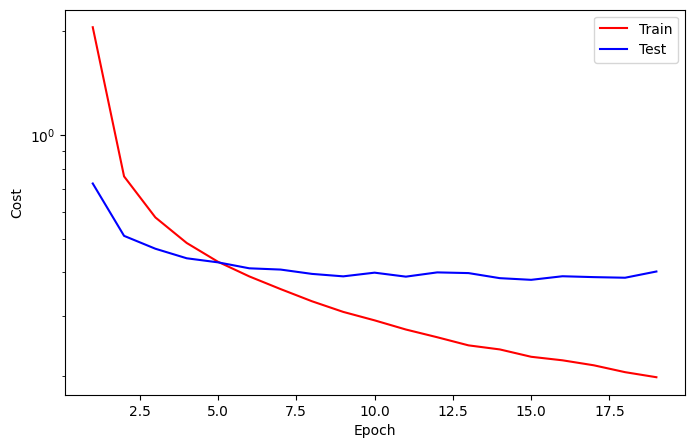

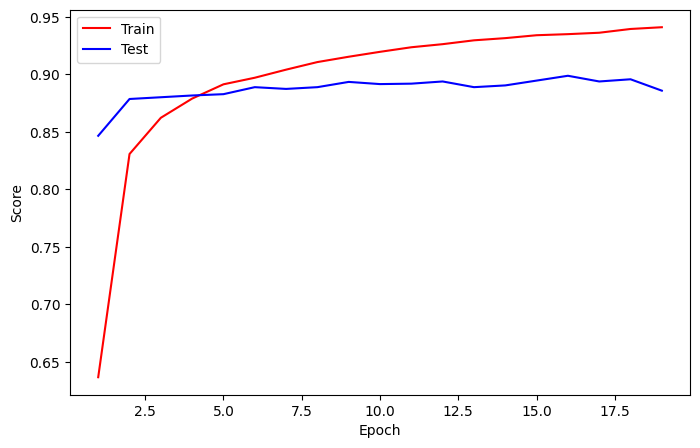

In [ ]:
while True:
  train_cost, train_score = loop_fn('train', train_set, train_loader,
                                    model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', val_set, validloader,
                                    model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor = 'test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

##### **3.2 Training Model from scratch**
* Unfreeze all parameters and run

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr = 1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 3

In [ ]:
while True:
  train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', val_set, validloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

### **4. Evaluate Model**

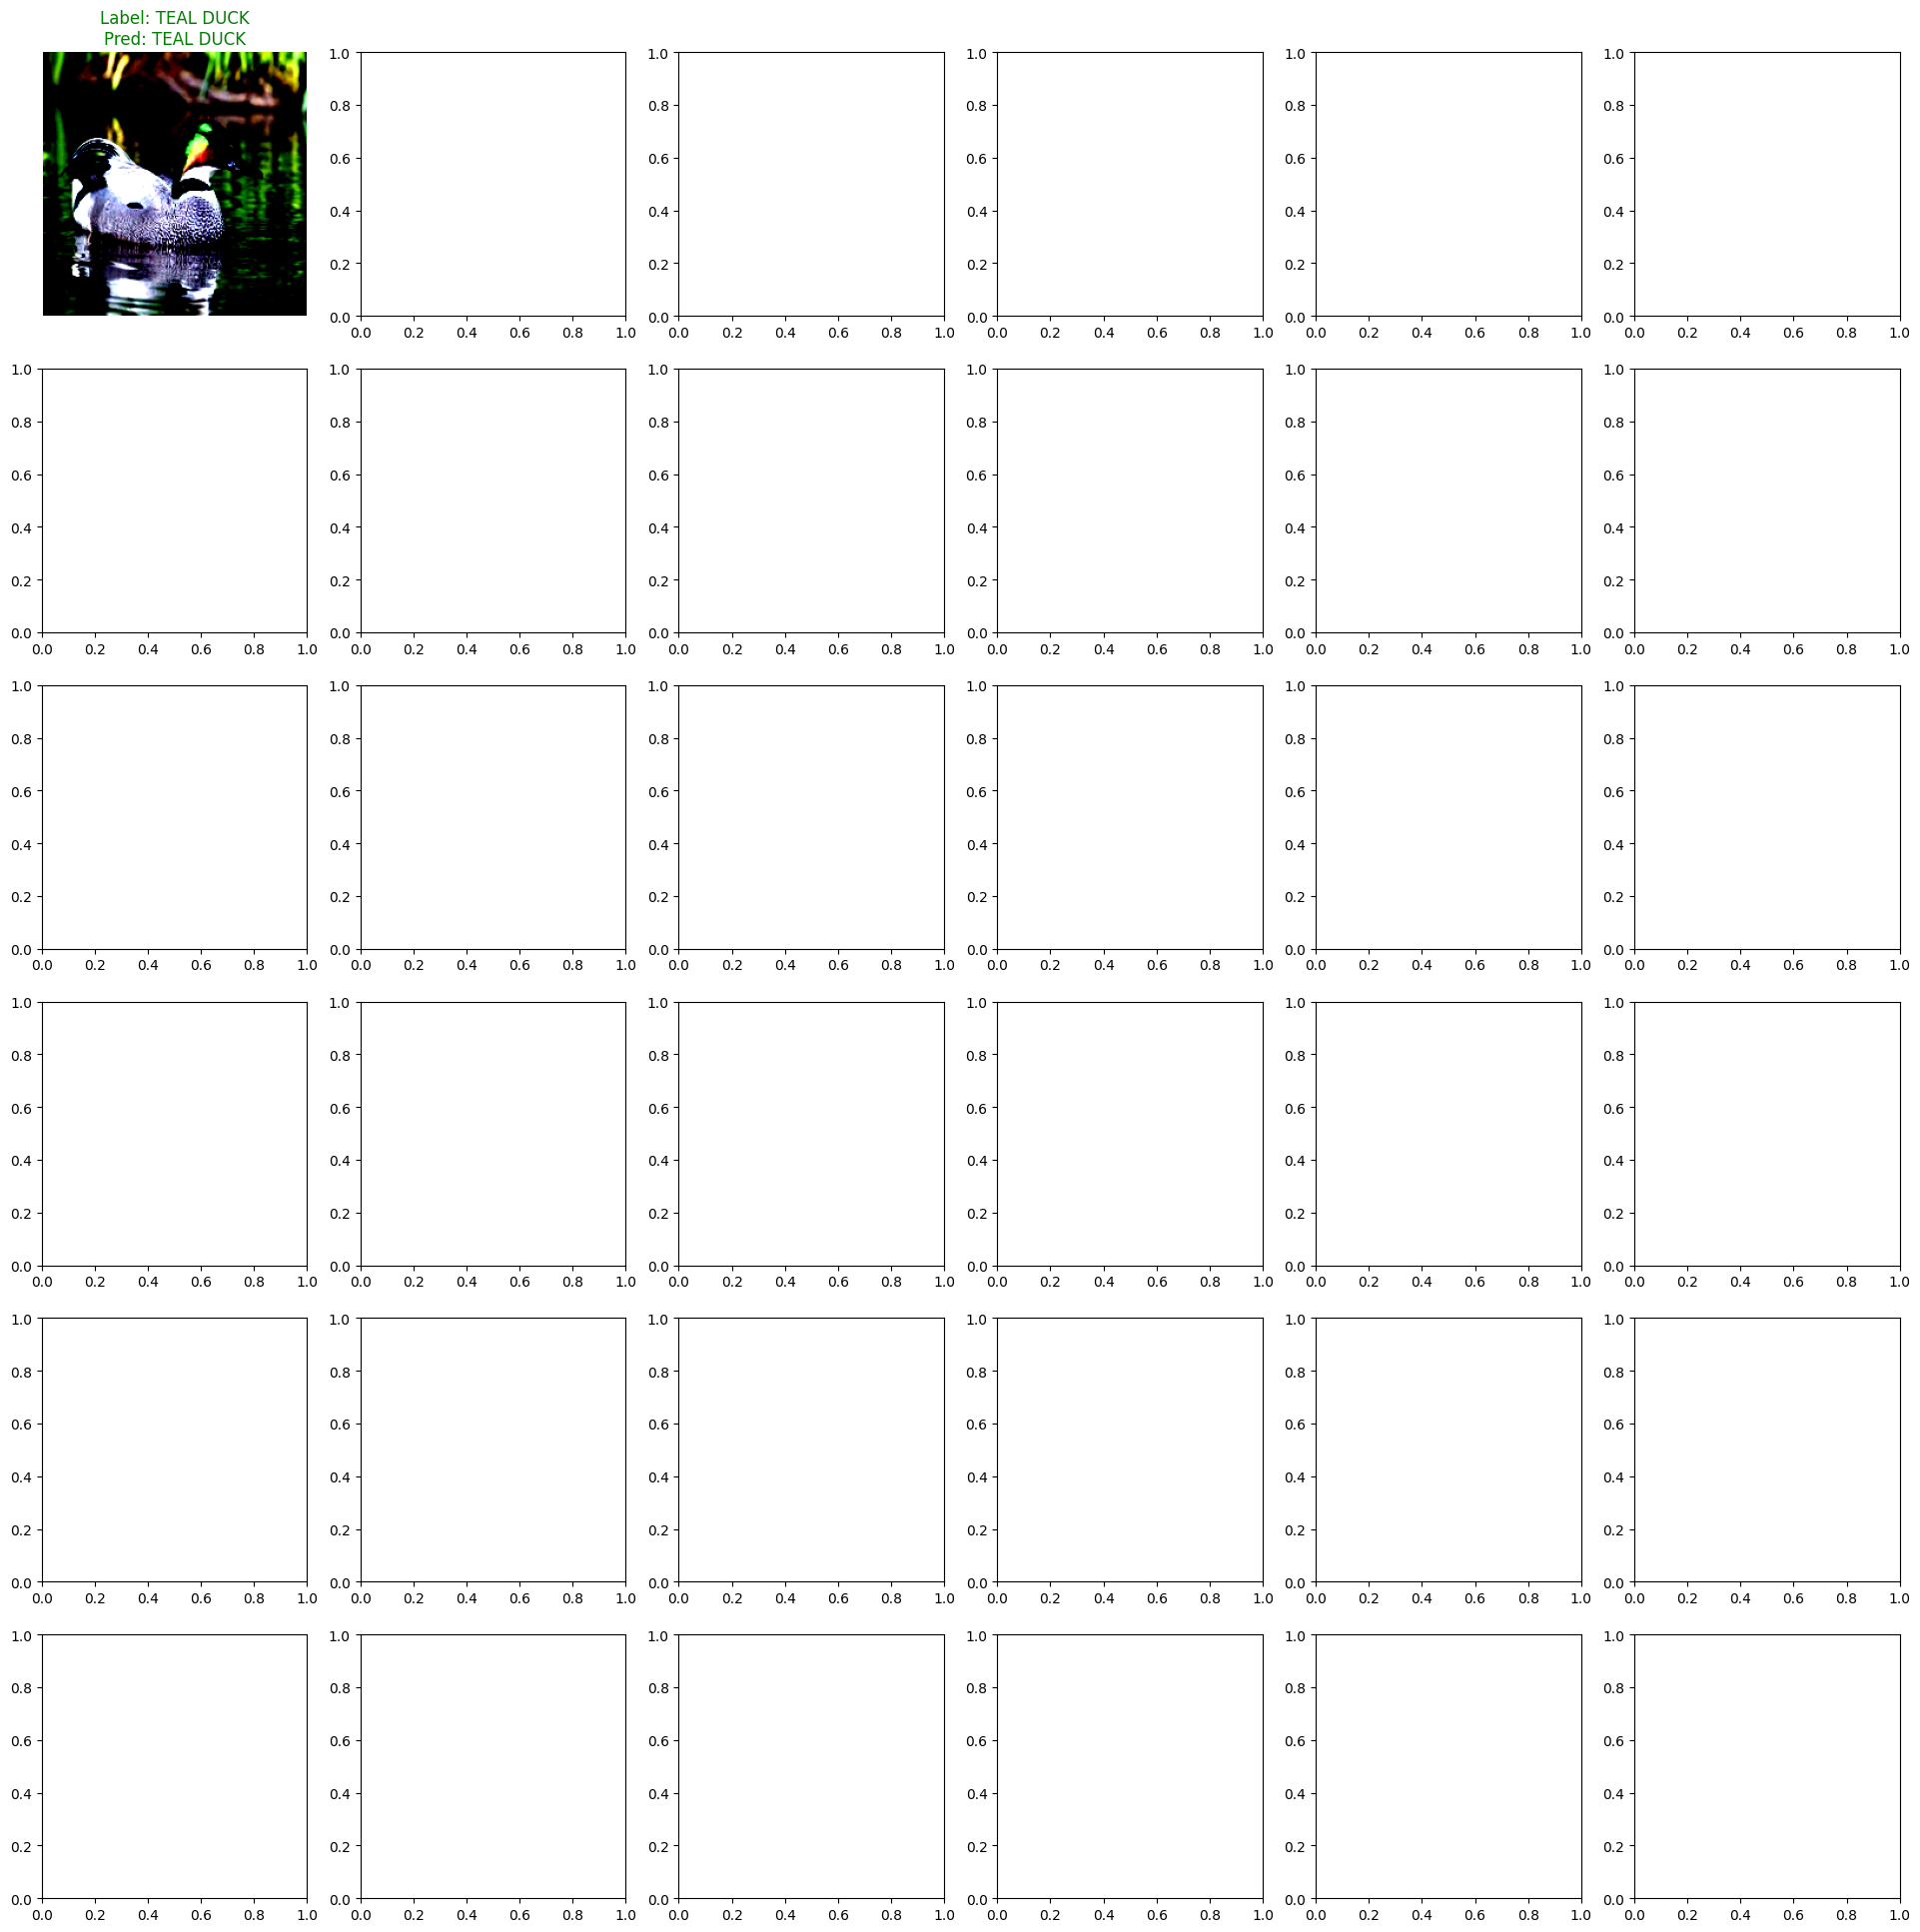

In [ ]:
for feature, target in testloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

fig, axes = plt.subplots(6, 6, figsize = (24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1, 2, 0).cpu())
  font = {'color': 'r'} if label != pred else {'color': 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f'Label: {label}\nPred: {pred}', fontdict = font);
  ax.axis('off')

In [ ]:
accuracy = []
for feature, target in testloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
    if(target == preds):
      acc = 1
    else:
      acc = 0
    accuracy.append(acc)
accuracy = np.array(accuracy)
accuracy.mean()

0.9104761904761904